**Clone Git Repo**  

In [1]:
!git clone https://github.com/hunter3789/Deep_Learning_QPF.git

Cloning into 'Deep_Learning_QPF'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 112 (delta 0), reused 0 (delta 0), pack-reused 111 (from 1)
Receiving objects: 100% (112/112), 181.57 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (31/31), done.


In [8]:
%cd Deep_Learning_QPF

/content/Deep_Learning_QPF


In [14]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/Deep_Learning_QPF')
from work.models_gan import load_model
from work.load_dataset_gan import load_data

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA not available, using CPU")
    device = torch.device("cpu")

# load model
model_gen = load_model('regressor', with_weights=True)

# load files
mean_std_file = './work/trainset_ssrd_agg_mean_std.npz'
mean, std = np.load(mean_std_file)['mean'], np.load(mean_std_file)['std']

label_mean_std_file = './work/trainset_label_agg_mean_std.npz'
label_mean, label_std = np.load(label_mean_std_file)['mean'], np.load(label_mean_std_file)['std']

topo_file = './work/topo_norm.npz'
topo = np.load(topo_file)['topo']

# load sample data
inference_data = load_data(mean=mean, std=std, topo=topo, label_mean=label_mean, label_std=label_std, dataset_path="./sample", shuffle=True, batch_size=1, num_workers=0, transform_pipeline="default")

CUDA not available, using CPU


In [47]:
# inference
model_gen.eval()

with torch.inference_mode():
    for data in inference_data:
        img, label, mask = data['image'], data['label'], data['mask']
        img, label, mask = img.to(device), label.to(device), mask.to(device)
        label = label.type(torch.float32)

        pred = model_gen(img).squeeze()
        break

print(pred.shape)

torch.Size([720, 576])


In [29]:
from work.plot_inference import get_linecollection, visualize

In [37]:
def get_linecollection():
    mapH5_NX, mapH5_NY, mapH5_SX, mapH5_SY = 5760/2, 5760/2, 3328/2, 3328/2
    map_NX, map_NY, map_SX, map_SY = 576, 720, 560/2, 840/2
    ox = mapH5_SX - map_SX
    oy = mapH5_SY - map_SY

    coords = []

    map_file = './work/DFS_mapH5s.bln'
    with open(map_file, mode='rb') as file:
        while True:
            data = file.read(4*2)

            if not data:
                break
            else:
                num_iter = struct.unpack('I'*2, data)[0]

            #print(num_iter)

            for i in range(num_iter):
                x2, y2 = struct.unpack('f'*2, file.read(4*2))
                x2 /= 2;
                y2 /= 2;
                x2 -= ox
                y2 -= oy

                if i > 0:
                    x3 = x1
                    y3 = y1

                    if x1 == x2 or y1 == y2:
                        continue

                    if x1 < 0:
                        x3 = 0
                        y3 = (y2-y1)/(x2-x1)*(-x1) + y1

                        if y3 < 0:
                            x3 = (x2-x1)/(y2-y1)*(-y1) + x1
                            y3 = 0
                        elif y3 > map_NY:
                            x3 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y3 = map_NY
                    elif x1 > map_NX:
                        x3 = map_NX
                        y3 = (y2-y1)/(x2-x1)*(map_NX-x1) + y1

                        if y3 < 0:
                            x3 = (x2-x1)/(y2-y1)*(-y1) + x1
                            y3 = 0
                        elif y3 > map_NY:
                            x3 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y3 = map_NY
                    else:
                        if y1 < 0:
                           x3 = (x2-x1)/(y2-y1)*(-y1) + x1
                           y3 = 0
                        elif y1 > map_NY :
                            x3 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y3 = map_NY

                    if x3 > map_NX or x3 < 0:
                        continue

                    x4 = x2
                    y4 = y2

                    if x2 < 0:
                        x4 = 0
                        y4 = (y2-y1)/(x2-x1)*(-x1) + y1

                        if y4 < 0:
                            x4 = (x2-x1)/(y2-y1)*(-y1) + x1
                            y4 = 0
                        elif y4 > map_NY:
                            x4 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y4 = map_NY
                    elif x2 > map_NX:
                        x4 = map_NX
                        y4 = (y2-y1)/(x2-x1)*(map_NX-x1) + y1

                        if y4 < 0:
                            x4 = (x2-x1)/(y2-y1)*(-y1) + x1
                            y4 = 0
                        elif y4 > map_NY:
                            x4 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y4 = map_NY
                    else:
                        if y2 < 0:
                           x4 = (x2-x1)/(y2-y1)*(-y1) + x1
                           y4 = 0
                        elif y2 > map_NY :
                            x4 = (x2-x1)/(y2-y1)*(map_NY-y1) + x1
                            y4 = map_NY

                    if x4 > map_NX or x4 < 0:
                        continue

                    coords.append(([x1, y1], [x2, y2]))

                x1, y1 = x2, y2

    return coords

In [43]:
def visualize(
    case,
    pred,
    label,
    mask,
    **kwargs,
):

    levels = [0, 0.5, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 100]
    levels_str = ['0', '0.5', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '100']
    cmap = ListedColormap([(1,1,1), (184/255,184/255,255/255), (127/255,153/255,229/255), (127/255,180/255,210/255), (127/255,210/255,180/255), (200/255,255/255,150/255),
                           (150/255,255/255,120/255), (100/255,250/255,100/255), (50/255,240/255,50/255), (255/255,255/255,180/255), (255/255,255/255,130/255), (255/255,250/255,80/255),
                           (255/255,240/255,50/255), (255/255,210/255,150/255), (255/255,180/255,120/255), (255/255,150/255,90/255), (255/255,100/255,50/255),
                           (255/255,75/255,40/255), (255/255,50/255,30/255), (255/255,25/255,19/255), (250/255,0,0)])

    norm = mc.BoundaryNorm(levels, cmap.N)

    coords = get_linecollection()
    map_NX, map_NY, map_SX, map_SY = 576, 720, 560/2, 840/2
    mesh_x, mesh_y = np.meshgrid(np.linspace(1,map_NX,map_NX), np.linspace(1,map_NY,map_NY))

    pred  = pred.squeeze()
    label = label.squeeze()
    mask  = mask.squeeze()

    pred  = pred.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    mask  = mask.detach().cpu().numpy()

    pred = pred*label_std + label_mean
    pred = np.power(10, pred) - 0.1
    label = np.ma.masked_where(label < 0, label)

    fig, ax = plt.subplots(1, 2, figsize=(12,6.25))
    ax[0].set_xlim(1,map_NX)
    ax[0].set_ylim(1,map_NY)
    ax[1].set_xlim(1,map_NX)
    ax[1].set_ylim(1,map_NY)

    ax[0].contour(mesh_x, mesh_y, mask, colors='lightblue', linewidths=1)
    draw0 = ax[0].pcolormesh(label, cmap=cmap, norm=norm)

    draw1 = ax[1].pcolormesh(pred, cmap=cmap, norm=norm)

    lc = LineCollection(coords, linewidth=0.5, color="black")
    ax[0].add_collection(lc)
    ax[0].set_aspect('equal')
    ax[0].tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    lc = LineCollection(coords, linewidth=0.5, color="black")
    ax[1].add_collection(lc)
    ax[1].set_aspect('equal')
    ax[1].tick_params(left = False, right = False , labelleft = False ,
        labelbottom = False, bottom = False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    fig.colorbar(draw0, ax=ax[0])
    fig.colorbar(draw1, ax=ax[1])


    fig.suptitle("{case:%Y.%m.%d.%H:%M} KST".format(case=case))
    plt.tight_layout()
    plt.show()

In [35]:
import sys
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mc
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import struct
import numpy as np

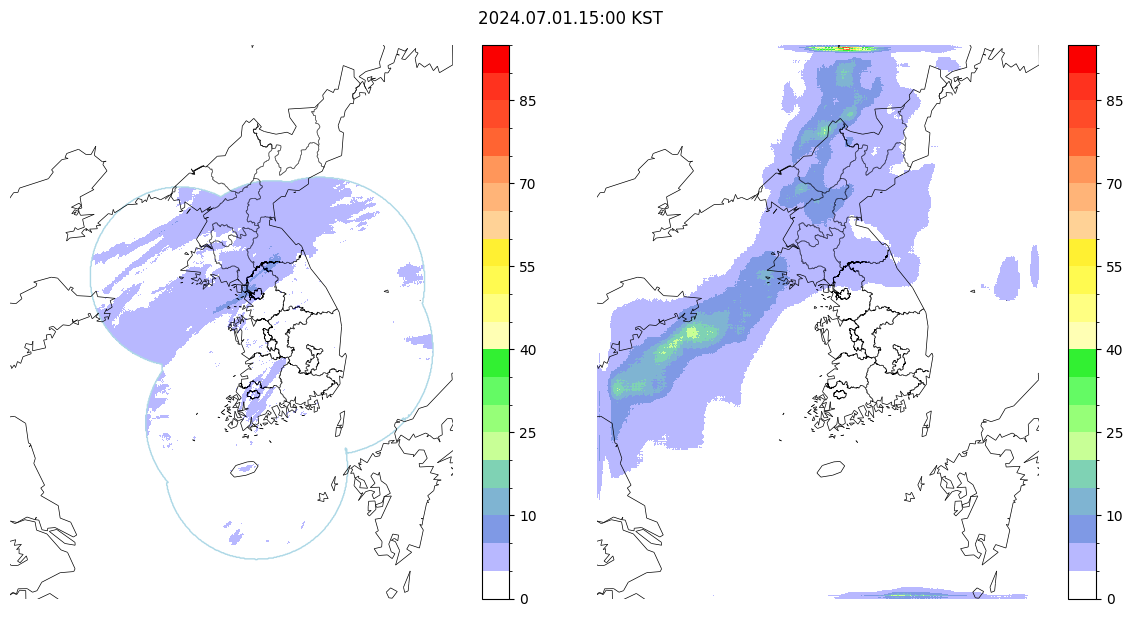

In [48]:
visualize(datetime(2024,7,1,15,0), pred, label, mask)